In [101]:
# importing required libraries
import pandas as pd
import numpy as np
from datetime import datetime
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import mplcursors

In [102]:
# return integer month, from string, default is 6
def month_to_number(month):
    if pd.isna(month):
        return 6
    try:
        # Try to convert directly to an integer
        month_number = int(month)
        if 1 <= month_number <= 12:
            return month_number
    except ValueError:
        # If month is a string, convert it to lower case and map to month number
        month = month.lower()
        month_dict = {
            'january': 1, 'february': 2, 'march': 3,
            'april': 4, 'may': 5, 'june': 6,
            'july': 7, 'august': 8, 'september': 9,
            'october': 10, 'november': 11, 'december': 12
        }
        return month_dict.get(month, 6)  # Return 6 if month is not recognized
    return 6

# Function to calculate count of months since manufacting data(year, month)
def calculate_months_since_manufactured(row, current_year, current_month):
    year, month = row['year_of_vehicle_manufacture'], row['month_of_vehicle_manufacture']
    return (current_year - year) * 12 + (current_month - month)
    
# Fuction to mark columns as category type
def convert_columns_as_category(columns, data):
    for column in columns:
        data[column] = data[column].astype('category')

# Convert values to uppercase
def convert_values_to_uppercase(columns, data):
    for column in columns:
        data[column] = data[column].str.strip()
        data[column] = data[column].str.upper()

# Replace text which is matching with a pattern
def replace_text(pattern, data, column):
    data[column] = data[column].str.replace(pattern, '', regex=True)

# Prune data
def prune_data(data):
    # set month number, considering string, int, nan cases 
    data['month_of_vehicle_manufacture'] = data['month_of_vehicle_manufacture'].apply(month_to_number)
    # add months_since_manufactured column
    data['months_since_manufactured'] = data.apply(calculate_months_since_manufactured, axis=1, current_year=datetime.now().year, current_month=datetime.now().month)
    # remove redundant features
    data = data.drop(columns=['month_of_vehicle_manufacture', 'year_of_vehicle_manufacture', 'registered_color', 'vehicle_fuel_type', 'accidental_vehicle'], axis=1)
    # convert values to uppercase
    columns_to_be_upper_cased = ['vehicle_make', 'vehicle_model', 'car_variant', 'city']
    convert_values_to_uppercase(columns_to_be_upper_cased, data)
    # remove yyyy-yyyy or yyyy from vehicle_model
    pattern = r'\b\d{4}-\d{4}\b|\b\d{4}\b'
    replace_text(pattern, data, 'vehicle_model')
    # mark columns as category type
    categorical_columns = ['vehicle_make', 'vehicle_model', 'city', 'car_variant']
    convert_columns_as_category(categorical_columns, data)
    return data

# Data segregation basis on likeliness
def separate_on_the_basis_of_likeliness(data):
    # condition for more interested vehicle is non-accidental and has odometer reading
    condition = (data['Odometer_Reading_Present'] != 0) & (data['accidental_vehicle'].isna())
    data_more_liked = data[condition]
    data_less_liked = data[~condition]
    # remove redundant columns
    data_more_liked = data_more_liked.drop(columns=['Odometer_Reading_Present', 'accidental_vehicle'], axis=1)
    data_less_liked = data_less_liked.drop(columns=['Odometer_Reading_Present', 'accidental_vehicle'], axis=1)
    return data_more_liked, data_less_liked

In [103]:
def train_model_with_param_tuning(data_more_liked):
    max_depths = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
    learning_rates = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
    num_estimators = [3, 5, 6, 7, 8, 9, 10, 15, 20, 50, 100]
    x_axis = []
    test_errors = []
    train_errors = []
    for depth in max_depths:
        for learning_rate in learning_rates:
            for estimator_count in num_estimators:
                model_for_more_liked_data = XGBRegressor(enable_categorical=True, eval_metric='mae', booster='dart', max_depth=depth, learning_rate=learning_rate, n_estimators=estimator_count, random_state=42)
                test_error, train_error  = train_model(data_more_liked, model_for_more_liked_data)
                if (test_error < 150000) :
                    x_axis.append(f"{depth} {learning_rate} {estimator_count}")
                    test_errors.append(test_error)
                    train_errors.append(train_error)

    plot_errors(x_axis, test_errors, train_errors)

def plot_errors(x_axis, test_errors, train_errors):
    # Activate interactive plot in separate window
    %matplotlib qt
    # Create a figure and axis
    fig, ax = plt.subplots()
    # Plot the data
    ax.plot(x_axis, test_errors, label='Test Errors', marker='o')
    ax.plot(x_axis, train_errors, label='Train Errors', marker='o')
    # Add labels and title
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Error')
    ax.set_title('Zoomable Graph with Test and Train Errors')
    # Enable interactive cursor for zooming
    mplcursors.cursor(hover=True)
    # Add legend
    plt.legend()
    # Display the plot
    plt.show()

def plot_feature_importance(model, columns):
    feature_importances = model.feature_importances_  
    # Create a DataFrame for better visualization
    importance_df = pd.DataFrame({
        'Feature': columns,
        'Importance': feature_importances
    })
    # Sort the DataFrame by importance
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    # Visualize the feature importances
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.title('Feature Importances')
    plt.gca().invert_yaxis()
    plt.show()

In [104]:
def train_model(df, model):
    train_data = df.sample(frac = 0.8)
    test_data = df.drop(train_data.index)
    train_inputs = train_data.drop(columns=['car_valuation'], axis=1)
    train_output = train_data['car_valuation']
    test_inputs = test_data.drop(columns=['car_valuation'], axis=1)
    test_output = test_data['car_valuation']
    model.fit(train_inputs, train_output)
    # mean absolute error on train data
    train_prediction = model.predict(train_inputs)
    train_error = mean_absolute_error(train_prediction, train_output)
    # mean absolute error on test data
    test_predicted_output = model.predict(test_inputs)
    test_error = mean_absolute_error(test_predicted_output, test_output)
    print("test_error= ",test_error," train_error= ", train_error)
    # Plot Feature Importance
    plot_feature_importance(model, train_inputs.columns)
    return test_error, train_error

In [105]:
model = XGBRegressor(enable_categorical=True, eval_metric='mae', booster='dart', max_depth=10, learning_rate=0.5, n_estimators=5, random_state=42)
    
# Training
def prune_data_and_train_model(data):
    data = prune_data(data)
    data = data.drop(columns=['id'], axis=1)
    # Tuning Params
    # train_model_with_param_tuning(data_more_liked)
    train_model(data, model)

In [106]:
# model_for_more_liked_data = XGBRegressor(enable_categorical=True, eval_metric='mae', booster='dart', max_depth=8, learning_rate=0.4, n_estimators=20, random_state=42)
# model_for_less_liked_data = XGBRegressor(enable_categorical=True, eval_metric='mae', booster='dart', max_depth=8, learning_rate=0.4, n_estimators=20, random_state=42)
    
# # Training
# def prune_data_and_train_model(data):
#     data = prune_data(data)
#     data = data.drop(columns=['id'], axis=1)
#     # data_more_liked, data_less_liked = separate_on_the_basis_of_likeliness(data)
#     # Tuning Params
#     # train_model_with_param_tuning(data_more_liked)
#     train_model(data_more_liked, model_for_more_liked_data)
#     train_model(data_less_liked, model_for_less_liked_data)

test_error=  190585.8775  train_error=  13645.050062189055


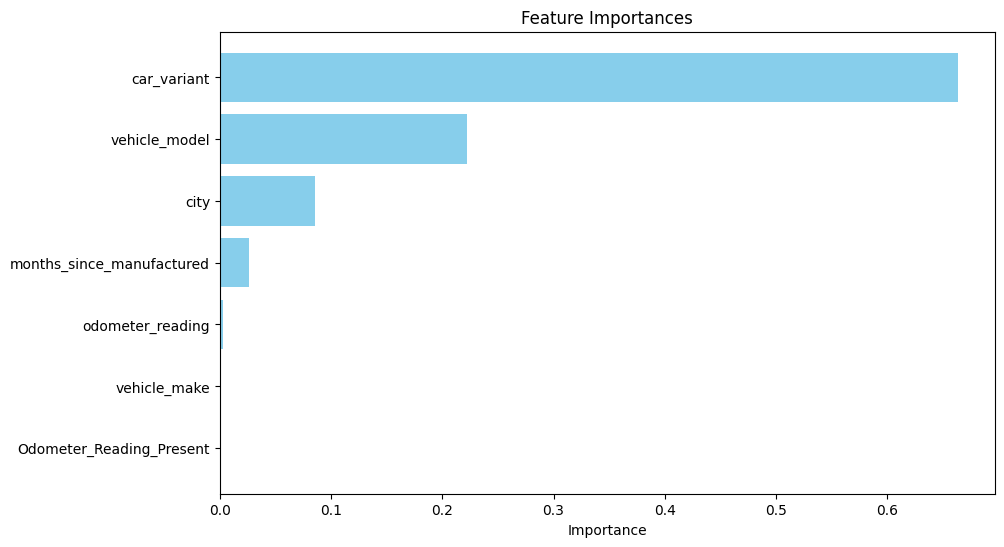

In [107]:
data = pd.read_csv('/Users/vikash.yadav/Documents/data_science_hackathon/train.csv')
prune_data_and_train_model(data)

In [108]:
# return ids and predicted outcome using model
def run_model(data, model):
    ids = data['id']
    data = data.drop(columns=['id'], axis=1)
    predicted_output = model.predict(data)
    return ids, predicted_output

# predict outcomes and save in file
# def predict_output_separately_and_save(ids_original_order, data_more_liked, model_for_more_liked_data, data_less_liked, model_for_less_liked_data):
#     ids_more_liked, prediction_for_more_liked_data = run_model(data_more_liked, model_for_more_liked_data)
#     ids_less_liked, prediction_for_less_liked_data = run_model(data_less_liked, model_for_less_liked_data)
#     ids = []
#     for id_more_liked in ids_more_liked:
#         ids.append(id_more_liked)
#     for id_less_liked in ids_less_liked:
#         ids.append(id_less_liked)
    
#     car_valuations = []
#     for valuation in prediction_for_more_liked_data:
#         car_valuations.append(int(valuation))
#     for valuation in prediction_for_less_liked_data:
#         car_valuations.append(int(valuation))
#     print(len(car_valuations))
    
#     df = pd.DataFrame({
#         'id': ids,
#         'car_valuation': car_valuations
#     })
#     df.to_csv('/Users/vikash.yadav/Documents/data_science_hackathon/car_valuation_data.csv', index=False)

# predict outcomes and save in file
def predict_output_and_save(ids_original_order, data, model):
    ids, car_valuations = run_model(data, model)
    car_valuations = car_valuations.astype(int)
    # ids = []
    # for id_more_liked in ids_more_liked:
    #     ids.append(id_more_liked)
    # for id_less_liked in ids_less_liked:
    #     ids.append(id_less_liked)
    
    # car_valuations = []
    # for valuation in prediction_for_more_liked_data:
    #     car_valuations.append(int(valuation))
    # for valuation in prediction_for_less_liked_data:
    #     car_valuations.append(int(valuation))
    # print(len(car_valuations))
    
    df = pd.DataFrame({
        'id': ids,
        'car_valuation': car_valuations
    })
    df.to_csv('/Users/vikash.yadav/Documents/data_science_hackathon/car_valuation_data.csv', index=False)

# def predict_output(data, model_for_more_liked_data, model_for_less_liked_data):
#     ids = data['id']
#     data = prune_data(data)
#     data_more_liked, data_less_liked = separate_on_the_basis_of_likeliness(data)
#     predict_output_separately_and_save(ids, data_more_liked, model_for_more_liked_data, data_less_liked, model_for_less_liked_data)

def predict_output(data, model):
    ids = data['id']
    data = prune_data(data)
    data.to_csv('/Users/vikash.yadav/Documents/data_science_hackathon/pruned_data.csv', index=False)
    print(data.columns)
    predict_output_and_save(ids, data, model)

In [109]:
test_data = pd.read_csv('/Users/vikash.yadav/Documents/data_science_hackathon/test.csv')
predict_output(test_data, model)

Index(['id', 'car_variant', 'odometer_reading', 'Odometer_Reading_Present',
       'vehicle_make', 'vehicle_model', 'city', 'months_since_manufactured'],
      dtype='object')
